#Tracking# 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    pass
    
# built in python modules
import datetime
import logging
import os
import inspect

# python add-ons
import numpy as np
import pandas as pd

In [2]:
import pvlib
from pvlib.tools import cosd, sind
from pvlib.location import Location

Make some Location objects.

In [5]:
tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')
print(tus)
golden = Location(39.742476, -105.1786, 'America/Denver', 1830, 'Golden')
print(golden)
golden_mst = Location(39.742476, -105.1786, 'MST', 1830, 'Golden MST')
print(golden_mst)

Tucson: latitude=32.2, longitude=-111, tz=US/Arizona, altitude=700
Golden: latitude=39.742476, longitude=-105.1786, tz=America/Denver, altitude=1830
Golden MST: latitude=39.742476, longitude=-105.1786, tz=MST, altitude=1830


In [6]:
times = pd.date_range(start=datetime.datetime(2014,3,23), end=datetime.datetime(2014,3,24), freq='5Min')
times_loc = times.tz_localize(tus.pytz)

In [8]:
pyephemout = pvlib.solarposition.pyephem(times, tus)

Here's an inline version of the tracking algorithm.

In [33]:
SunAz = pyephemout['apparent_azimuth']
SunZen = pyephemout['apparent_zenith']
AxisTilt = 0
AxisAzimuth = 0
Latitude = 32
MaxAngle = 90 
Backtrack = True
GCR = 2.0/7.0
    

times = SunAz.index

Az = SunAz - 180
El = 90 - SunZen
x = cosd(El) * sind(Az)
y = cosd(El) * cosd(Az)
z = sind(El)
    
    
AxisAz = AxisAzimuth - 180;

 
xp = x*cosd(AxisAz) - y*sind(AxisAz);
yp = (x*cosd(AxisTilt)*sind(AxisAz) +
      y*cosd(AxisTilt)*cosd(AxisAz) -
      z*sind(AxisTilt))

zp = (x*sind(AxisTilt)*sind(AxisAz) +
      y*sind(AxisTilt)*cosd(AxisAz) +
      z*cosd(AxisTilt))

# The ideal tracking angle wid is the rotation to place the sun position 
# vector (xp, yp, zp) in the (y, z) plane; i.e., normal to the panel and 
# containing the axis of rotation.  wid = 0 indicates that the panel is 
# horizontal.  Here, our convention is that a clockwise rotation is 
# positive, to view rotation angles in the same frame of reference as 
# azimuth.  For example, for a system with tracking axis oriented south, 
# a rotation toward the east is negative, and a rotation to the west is 
# positive.

# can we use atan2?

# filter to avoid undefined inverse tangent
#tmp(xp~=0) = atand(zp./xp)  # angle from x-y plane to projection of sun vector onto x-z plane
tmp = np.degrees(np.arctan(zp/xp))  # angle from x-y plane to projection of sun vector onto x-z plane
#tmp(xp==0 & zp>=0) = 90     # fill in when atan is undefined
#tmp(xp==0 & zp<0) = -90     # fill in when atan is undefined
#tmp=tmp(:);                  # ensure tmp is a column vector
# Obtain wid by translating tmp to convention for rotation angles.
# Have to account for which quadrant of the x-z plane in which the sun 
# vector lies.  Complete solution here but probably not necessary to 
# consider QIII and QIV.
wid = pd.Series(index=times)
wid[(xp>=0) & (zp>=0)] =  90 - tmp[(xp>=0) & (zp>=0)];  # QI
wid[(xp<0)  & (zp>=0)] = -90 - tmp[(xp<0)  & (zp>=0)];  # QII
wid[(xp<0)  & (zp<0)]  = -90 - tmp[(xp<0)  & (zp<0)];   # QIII
wid[(xp>=0) & (zp<0)]  =  90 - tmp[(xp>=0) & (zp<0)];   # QIV
#wid=wid(:);                  # ensure wid is a column vector

# filter for sun above panel horizon)
#u = zp > 0;

# apply limits to ideal rotation angle
#wid(~u) = 0;  # set horizontal if zenith<0, sun is below panel horizon

# Account for backtracking; modified from [1] to account for rotation
# angle convention being used here.
if Backtrack:
    Lew = 1/GCR
    temp = np.minimum(Lew*cosd(wid), 1)
    wc = np.degrees(np.arccos(temp))   # backtrack angle; always positive (acosd returns values between 0 and 180)
    v = wid < 0
    widc = pd.Series(index=times)
    widc[~v] = wid[~v] - wc[~v] # Eq 4 applied when wid in QI
    widc[v] = wid[v] + wc[v]    # Eq 4 applied when wid in QIV
else:
    widc = wid

#TrkrTheta[u] = widc[u];
#TrkrTheta(~u) = 0;    # set to zero when sun is below panel horizon
#TrkrTheta = TrkrTheta(:);   # ensure column vector format
TrkrTheta = widc.copy()
TrkrTheta[TrkrTheta > MaxAngle] = MaxAngle
TrkrTheta[TrkrTheta < -MaxAngle] = -MaxAngle

# calculate normal vector to panel in panel-oriented x, y, z coordinates
# y-axis is axis of tracker rotation.  TrkrTheta is a compass angle
# (clockwise is positive) rather than a trigonometric angle.

Norm = np.array([sind(TrkrTheta), np.zeros_like(TrkrTheta), cosd(TrkrTheta)])

# sun position in vector format in panel-oriented x, y, z coordinates
P = np.array([xp, yp, zp])

# calculate angle-of-incidence on panel
AOI = np.degrees(np.arccos(np.abs(np.sum(P*Norm, axis=0))))

Rot_x = np.array([[1, 0, 0], 
                  [0, cosd(-AxisTilt), -sind(-AxisTilt)], 
                  [0, sind(-AxisTilt), cosd(-AxisTilt)]])
temp = np.dot(Rot_x, Norm) # temp contains the normal vector expressed in earth-surface coordinates (z normal to surface, y aligned with tracker axis parallel to earth)
temp = temp.T  # ensure column format # @wholmgren what?
# projection to plane tangent to earth surface, in earth surface coordinates
projNorm = np.array([temp[:,0], temp[:,1], np.zeros_like(temp[:,2])]) 
tempnorm = np.sqrt(np.nansum(temp**2, axis=1))
projNormnorm = np.sqrt(np.nansum(projNorm**2, axis=1))

#SurfAz = 0.*TrkrTheta;
# calculation of SurfAz
projNorm = projNorm.T
SurfAz = np.degrees(np.arctan(projNorm[:,1]/projNorm[:,0]))

# clean up atan when x-coord is zero
#SurfAz[projNorm(:,1)==0 & projNorm(:,2)>0] =  90;
#SurfAz[projNorm(:,1)==0 & projNorm(:,2)<0] =  -90;
# clean up atan when y-coord is zero
#SurfAz[projNorm(:,2)==0 & projNorm(:,1)>0] =  0;
#SurfAz[projNorm(:,2)==0 & projNorm(:,1)<0] = 180;
# correct for QII and QIII
SurfAz[(projNorm[:,0]<0) & (projNorm[:,1]>0)] += 180 # QII
SurfAz[(projNorm[:,0]<0) & (projNorm[:,1]<0)] += 180 # QIII

# at this point SurfAz contains angles between -90 and +270, where 0 is
# along the positive x-axis, the y-axis is in the direction of the tracker
# azimuth, and positive angles are rotations from the positive x axis towards
# the positive y-axis.
# Adjust to compass angles (clockwise rotation from 0 along the positive y-axis)
SurfAz[SurfAz<=90] = 90 - SurfAz[SurfAz<=90]
SurfAz[SurfAz>90] = 450 - SurfAz[SurfAz>90]

# finally rotate to align y-axis with true north
if Latitude>0:
    SurfAz = SurfAz - AxisAzimuth
else:
    SurfAz = SurfAz - AxisAzimuth - 180
SurfAz[SurfAz<0] = 360 + SurfAz[SurfAz<0]

#divisor = np.round(tempnorm*projNormnorm*10000)/10000
#dividend = np.round(temp*projNorm*10000)/10000


#SurfTilt = 90 - np.degrees(np.arccos(dividend/divisor))

df_out = pd.DataFrame({'AOI':AOI,
                       'SurfAz':SurfAz,
                       'SurfTilt':np.nan},
                      index=times)

df_out[SunZen > 90] = np.nan

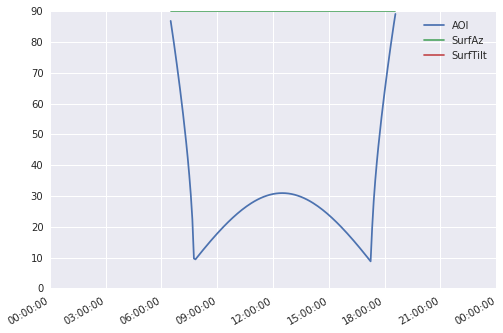

In [35]:
df_out.plot()

In [36]:
reload(pvlib.tracking)

<module 'pvlib.tracking' from '/home/will/git_repos/pvlib-python/pvlib/tracking.py'>

With backtracking

In [40]:
tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=0, AxisAzimuth=0, MaxAngle=90,
                                         Backtrack=True, GCR=2.0/7.0)

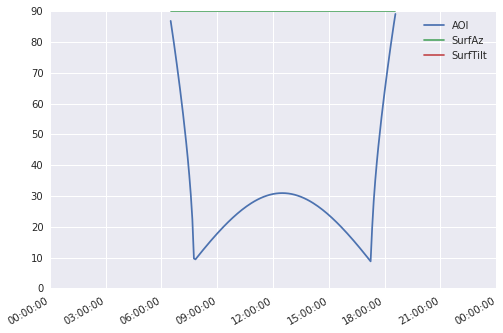

In [41]:
tracker_data.plot()

Without backtracking

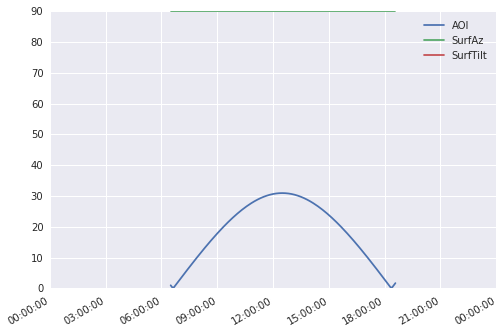

In [39]:
tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=0, AxisAzimuth=0, MaxAngle=90,
                                         Backtrack=False, GCR=2.0/7.0)
tracker_data.plot()

Explore ground cover ratio

In [44]:
np.linspace(0, 1, 6)

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [45]:
aois = pd.DataFrame(index=pyephemout.index)

tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=0, AxisAzimuth=0, MaxAngle=90,
                                         Backtrack=False, GCR=2.0/7.0)
aois['no backtrack'] = tracker_data['AOI']

for gcr in np.linspace(0, 1, 6):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=0, AxisAzimuth=0, MaxAngle=90,
                                         Backtrack=True, GCR=gcr)
    aois[gcr] = tracker_data['AOI']

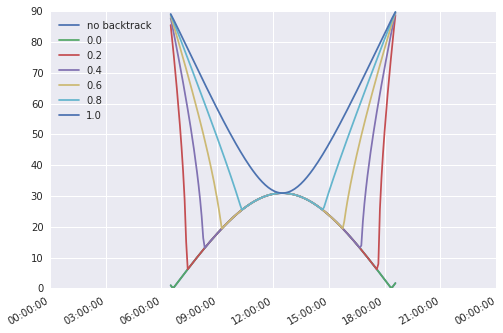

In [47]:
aois.plot()

Ensure that MaxAngle works.

(0, 90)

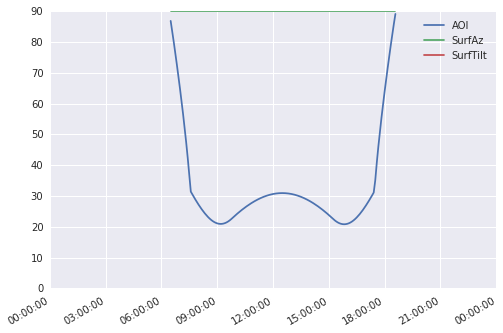

In [51]:
tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=0, AxisAzimuth=0, MaxAngle=45,
                                         Backtrack=True, GCR=2.0/7.0)
tracker_data.plot()
plt.ylim(0,90)

MaxAngle has the right behavior at least.

Play with AxisTilt.

(0, 90)

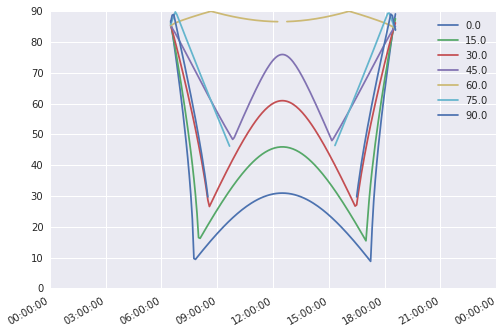

In [56]:
aois = pd.DataFrame(index=pyephemout.index)

for tilt in np.linspace(0, 90, 7):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=tilt, AxisAzimuth=0, MaxAngle=90,
                                         Backtrack=True, GCR=2/7.)
    aois[tilt] = tracker_data['AOI']
    
aois.plot()
plt.ylim(0,90)

Makes sense if the panels are facing north at solar noon.

(0, 90)

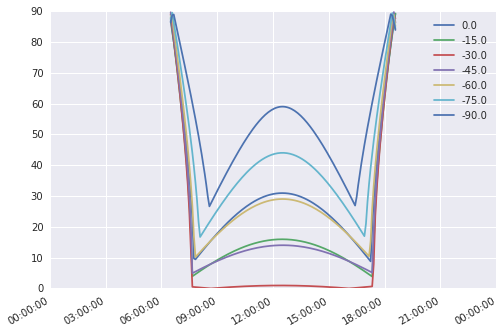

In [61]:
aois = pd.DataFrame(index=pyephemout.index)

for tilt in np.linspace(0, -90, 7):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=tilt, AxisAzimuth=0, MaxAngle=90,
                                         Backtrack=True, GCR=2/7.)
    aois[tilt] = tracker_data['AOI']
    
aois.plot()
plt.ylim(0,90)

Makes sense if the panels are facing south at solar noon.

Play with AxisAzimuth

(0, 90)

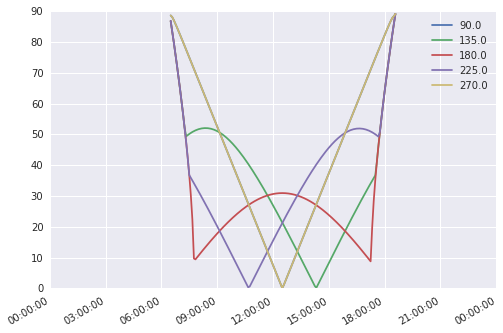

In [60]:
aois = pd.DataFrame(index=pyephemout.index)

for azi in np.linspace(90, 270, 5):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         Latitude=tus.latitude, AxisTilt=0, AxisAzimuth=azi, MaxAngle=90,
                                         Backtrack=True, GCR=2/7.)
    aois[azi] = tracker_data['AOI']
    
aois.plot()
plt.ylim(0,90)

I think that's right...

Intermediate outputs from inline algorithm

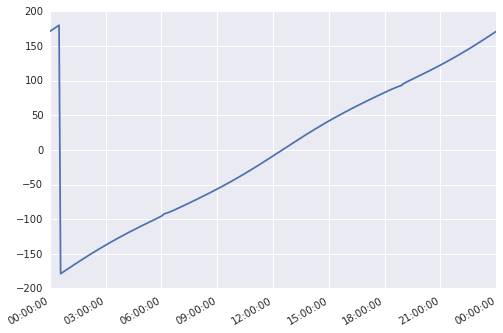

In [199]:
wid.plot()

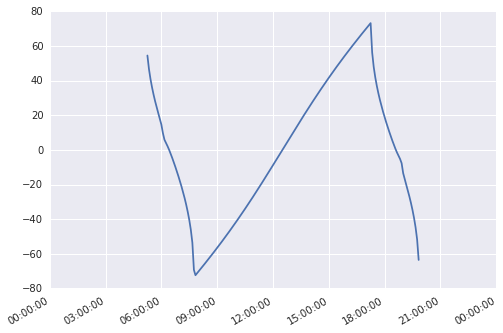

In [200]:
widc.plot()

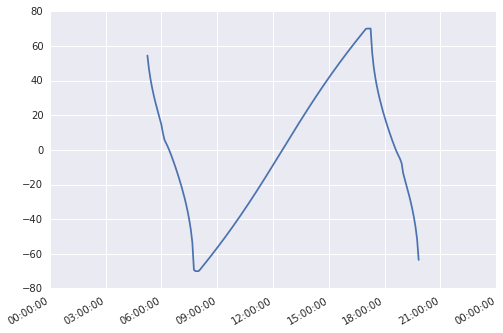

In [201]:
TrkrTheta.plot()